<br> 

#### 0. Prepare dataset 

- keras에서 model 저장할 때 방법 두 가지

1. 학습이 완료된 상태에서 model 저장 
2. 학습하면서 epoch가 끝날 때마다 파일로 저장 (중간 저장)
> 2번 방법의 경우 overfiting이 시작되기 전으로 되돌리거나 혹시나 커널이 꺼졌을 때 꺼지기 이전까지 돌아간 epoch별 model 파일 되살릴 수 있음

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
# 딥러닝 할 때도 sklearn을 통해 train test split, pipeline을 통한 원핫 인코딩 등 적용해야 하므로 해당 라이브러리 사용함 (전처리에 한해서 사용하는 것)

In [5]:
titanic_df = pd.read_csv("titanic_modified.csv") # 전처리가 끝난 titanic data load

titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [6]:
titanic_data.head(3)

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,2.0,0.0,2,4,0.4,0
2,3,1,1.0,0.0,0,2,0.0,1


In [7]:
titanic_target.head(3)

,Survived
0,0
1,1
2,1


In [8]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data, titanic_target,
                                                                                 test_size=0.3,
                                                                                 random_state=0)

In [9]:
# sklearn에 있는 onehotencoder
# enc = preprocessing.OneHotEncoder(categories='auto') 
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

In [10]:
# tensorflow.keras에 있는 onehotencoder
from tensorflow.keras import utils 

train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)

둘 중에 어떤 것을 써도 관계 x 

In [11]:
train_label

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

<br> 

#### 1. Train the model

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [13]:
model = models.Sequential() 

# batch normalization 및 flatten 안 해줬으므로 input_dim에 x 데이터 열의 수 적어줘야 함 
# 현재 titanic_df에서 x 데이터 열의 수 8개 

# 첫 번째 hidden layer 
model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.BatchNormalization()) # 원한다면 Activation 이전에 써줄 것 
model.add(layers.Activation('elu')) # elu or relu

# 두 번째 hidden layer 
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

# 세 번째 hidden layer 
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# 네 번째 hidden layer 
model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=2, activation='softmax')) # One-hot vector for 0 & 1
# 원핫인코딩을 통해 정답 데이터 열의 수가 2개가 되었으므로 units = 2 

In [14]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [15]:
# verbose의 값을 0으로 지정하면 silent mode로 fitting이 진행됩니다.

history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3, verbose=0) # verbose 수다쟁이 ^-^ 0으로 두면 epoch별 성능지표 수치값 안나옴  

<br> 

#### 2. Test the model before saving

In [16]:
result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 2ms/step - loss: 0.4815 - categorical_accuracy: 0.8134
loss (cross-entropy) : 0.4815240502357483
test accuracy : 0.8134328126907349


<br> 

#### 3. Save the trained model

In [17]:
model.summary() # model의 구조를 보여줌 
# 전체 레이어에 거쳐서 추가된 세타들의 총합까지 확인 가능 (total params)
# 이때 학습 가능하지 않은 파라미터 세타란? 
## model.save를 통해 모델을 저장하고 불러올 때 불러오는 대상이 되는 model을 
## 우리가 만든 모델이 아닌 학습이 완료된 다른 좋은 모델 가져다 쓸 수 있음 (전이학습)
## 그 과정에서 마지막 히든 레이어 한 두개만 추가하고 그 외 나머지 레이어와 파리미터 세타들을 
## 꽁꽁 얼려두기 때문에 (아래 코드 참조) 이때 non-trainable params 발생 가능 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

In [18]:
model.trainable = False # 세타들을 학습 가능하지 않은 상태로 만드는 것 
# 그리고 그 상태에서 히든 레이어 한 두개 추가로 쌓은 후 추가 학습하면 이게 바로 전이학습
# model.fit(~~~)
model.summary()
# Non-trainable params: 528,386 
# 즉, 다시 말해 파라미터 세타들을 동결시킨 것 (비유하자면..)
# 동결 후 model.fit을 통해 학습시켜도 학습되지 않음 (세타들이 변하지 않는 것)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

In [19]:
# 저장되는 항목 
# - Model의 architecture 모델의 구조 (레이어의 개수, 퍼셉트론의 개수, activation fuction의 종류 등)
# - Model의 모든 weights (Parameter Theta) 모델에 포함된 세타들 
# - The state of the optimizer (바로 모델 학습의 재개 가능) model.fit할 때 내부적으로 돌아가던 심부름꾼 (Gradient descent)
## 이때 optimizer이 저장되어 있으면, model을 불러왔을 때 model.fit을 추가로 하면 
## 직전이 학습이 마쳐진 상태에서 이어서 추가학습 가능 

model.save('trained_model.h5') # "Save" the model
# 이때 파일 확장자(h5)는 사실상 아무런 의미 없음 어떠한 역할도 없으므로 지워도 괜찮음

# model.save_weights('trained_model.h5') # weights만 따로 저장도 가능함 (즉, 세타만 저장)
# -> 모델이 복잡해질 경우 save로 한큐에 저장이 어렵기 때문에 위와 같이 세타값만 저장하는 경우 존재 

<br> 

#### 4. Load the saved model 

In [22]:
# from tensorflow.keras import models

# model = models.Sequential()

model = models.load_model('trained_model.h5') # "Load" the "model"
# 우리가 만들었던 모델 그대로 (세타값, 학습단계까지 유지된 상태 그대로) 불러오는 것 
# 해당 상태에서 model.fit을 통해 추가 학습 가능

# model.load_weights('trained_model.h5') # weights만 따로 불러올 수 있음

In [23]:
result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 2ms/step - loss: 0.4815 - categorical_accuracy: 0.8134
loss (cross-entropy) : 0.4815240502357483
test accuracy : 0.8134328126907349


<hr>

<br>

### Appendix) Save the model while training (+ Keras Callbacks API) > 트레이닝 과정에서 모델 저장 

<br>

#### Keras Callbacks API (Keras 콜백 함수)를 사용하는 이유 
<br>

- 모델의 **학습(fit)이 시작된 이후**에는 **학습 완료 전까지 사람이 컨트롤할 수 있는 것이 없음**
- 이를 해결하기 위한 도구가 Keras의 콜백 함수 (프로그래밍 전반에서의 콜백 함수 정의 : https://j.mp/3ibaAT4)
> 특정한 함수를 실행하는 과정에서 사용자가 원하는 시점에 추가로 다른 함수가 실행되도록 하는 것 (기존 모델 학습 과정에서는 모든 epoch가 돌아가고 학습이 완료될 때까지 멈출 수 없음-통제 불가)
- ex) 학습 중 Learning rate 값을 변화시키기 / 학습 중 일정 시간 성능 개선이 없을 경우 학습 조기 종료 / 학습 중 모델 중간 저장 등
- Keras Callbacks API 공식 문서 : https://keras.io/api/callbacks/

<br>

#### Keras Callback examples
<br>

- **ModelCheckpoint** (학습 중간 저장) : https://deep-deep-deep.tistory.com/53 + 아래 코드 참고 >> modelcheckpoint가 가장 많이 활용됨
- **EarlyStopping** (학습 조기 종료) : https://deep-deep-deep.tistory.com/55
- **ReduceLROnPlateau** (학습율 자동 조절) : https://deep-deep-deep.tistory.com/56 (Plateau란? @ https://j.mp/3B56FzJ)

In [26]:
# # 다양한 ModelCheckpoint 적용 예제 @ https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko#훈련하는_동안_체크포인트_저장하기
# # 아래 Parameter들의 상세 설명 @ https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

tf.keras.callbacks.ModelCheckpoint( 
    filepath, # 모델 저장 경로, if '{epoch:02d}-{val_loss:.5f}.h5' -> ex) 01(2자리 epoch 수)-0.39121(해당 epoch val_loss값).h5 
    monitor = 'val_loss', # 'loss', 'val_loss', 'accuracy', etc. 
    # ex. epoch 기준 check를 하면서 성능이 가장 좋게 나오는 시점에 모델 저장 > 이 기준을 monitor parameter에서 잡아줌 
    # val_loss: validation data 기준 complie 과정에서 지정한 loss 함수 계산 방법으로 학습했을 때 val_loss가 가장 낮아지는 시점에 모델 저장 
    # loss: train data 기준 loss 
    verbose = 0, # 0 or 1 (0가 default 값)
    save_best_only = False, # True : monitor 중인 지표 기준 가장 좋은 모델 저장 or False : 하단 save_freq 기준 주기적 저장
    save_weights_only = False, # True == model.save_weights(filepath) or False == model.save(filepath) - 저장 시 세타값만 저장할 것인가?
    mode = 'auto', # 'auto', 'min', 'max' (auto로 해주면 알아서 판단해줌)
    # monitor 할 대상에 대해서 낮아지는 것 or 높아지는 것이 좋은가? 
    # min -> 최소일 때 좋은 것 ex. loss
    # max -> 최대일 때 좋은 것 ex. accuracy 
    save_freq = 'epoch', # 'epoch' or integer(== # of batches) - 얼마만큼의 빈도로 저장할 것인가? 
    save_freq = 5 * number of batches # == saves the model's weights every 5 epochs (variable 'batch_size' should be set already)
    # batch data 기준 (한 epoch에 들어있는 batch기준) 5번 들어갈 때마다 저장 = 5 epoch마다 저장 
)

# 보통 filepath, save_best_only만 지정해준다. 

In [27]:
model = models.Sequential() 
model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) # elu or relu
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))
model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=2, activation='softmax')) # One-hot vector for 0 & 1

model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [28]:
# 모델 체크포인트 파일(중간 저장 모델)을 저장할 경로 설정 
checkpoint_path = 'saved_models/titanic_4-layer_elu.h5' # 필히 saved_models 폴더를 먼저 만들어줘야 합니다

# "ModelCheckpoint" 콜백함수 객체 생성
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)

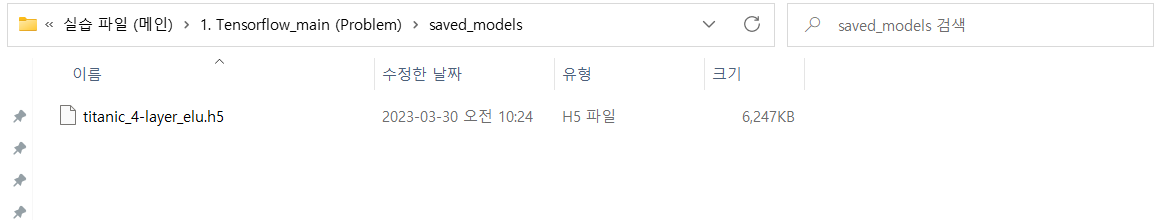

In [29]:
# 콜백함수를 호출하며 모델 학습 진행 
history = model.fit(train_data, train_label, 
                    batch_size=100, epochs=100, validation_split=0.3, verbose=0,
                    callbacks=[callback_checkpoint]) # 콜백 함수 추가

In [30]:
# 마지막 학습 완료 시점을 기준으로 한 모델 성능

result = model.evaluate(test_data, test_label)
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 993us/step - loss: 0.5194 - categorical_accuracy: 0.8134
loss (cross-entropy) : 0.5193967819213867
test accuracy : 0.8134328126907349


In [31]:
# 가장 낮은 Validation loss를 기준으로 한 (저장된) 모델 성능

model = models.load_model('saved_models/titanic_4-layer_elu.h5') # "Load" the "model"

result = model.evaluate(test_data, test_label)
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 1ms/step - loss: 0.4215 - categorical_accuracy: 0.8284
loss (cross-entropy) : 0.42151832580566406
test accuracy : 0.8283582329750061


In [ ]:
# end of file